### The mighty EDA notebook



In [1]:
# Import libraries

import os
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import keras
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from skimage import io

# Data dir
ROOT_DIR = os.path.abspath("../")
DATASET_PATH = os.path.join(ROOT_DIR, "dataset")

Using TensorFlow backend.


#### Read labels

In [2]:
dt = pd.read_csv(os.path.join(DATASET_PATH, 'metadata.csv'))
dt = dt[["survival", "modality", "filename"]].dropna()
dt = dt[dt.modality != "CT"]

dt.head()

,survival,modality,filename
0,Y,X-ray,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...
1,Y,X-ray,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...
2,Y,X-ray,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...
3,Y,X-ray,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...
9,N,X-ray,SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0....


In [3]:
# Labels
labels = dt[["survival"]].values

In [4]:
len(labels)

53

In [5]:
labels.shape

(53, 1)

In [8]:
image_path = dt["filename"].values
image_path[:10]

array(['auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
       'auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
       'auntminnie-c-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
       'auntminnie-d-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
       'SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0.jpeg',
       'SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5.jpeg',
       'SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10.jpeg',
       'SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day7.jpeg',
       'SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day12.jpeg',
       'SARS-10.1148rg.242035193-g04mr34g09a-Fig9a-day17.jpeg'],
      dtype=object)

### Data loader

In [9]:
# Classes for data loading and preprocessing
class COVIDChestXRayDataset:
    def __init__(
            self,
            datadir,
            csv_path,
            flag,
    ):
        
        # Patient names in folder
        #self.ids = sorted(os.listdir(datadir))
        # Sorted patient names in folder
        #self.images_fps = [os.path.join(datadir, image_id) for image_id in self.ids]
        

        # Read csv path
        csv = pd.read_csv(os.path.join(csv_path))
        csv = csv[["survival", "modality", "filename"]].dropna()
        csv = csv[csv.modality != "CT"]
        
        # Image names
        self.image_names = csv["filename"].values
        
        
        # Get labels
        self.labels = csv[["survival"]].values
        self.image_paths = [os.path.join(datadir, image_id) for image_id in self.image_names]
        
        # Split
        train_vols, test_vols, train_labels, test_labels = train_test_split(self.image_paths, self.labels, test_size=0.20, random_state=42)
        print(len(train_vols), len(test_vols))
        
        self.train_vols = train_vols
        self.test_vols = test_vols
        self.train_labels = train_labels
        self.test_labels = test_labels
        
        if flag == "train":
            self.image_paths = self.train_vols
            self.labels = self.train_labels
            self.ids = self.train_vols
            
        else:
            self.image_paths = self.test_vols
            self.labels = self.test_labels
            self.ids = self.test_vols
        
        
    def __getitem__(self, i):
        
        # Read data
        img = io.imread(self.image_paths[i])
        img = resize(img, (256, 256))
        
        img = img.astype(np.float32)
        img /= 255
        
        # Taken from https://github.com/mlmed/torchxrayvision/blob/master/torchxrayvision/datasets.py#L814
        # Check that images are 2D arrays
        if len(img.shape) > 2:
            img = img[:, :, 0]
        if len(img.shape) < 2:
            print("error, dimension lower than 2 for image")

        # Add color channel
        img = img[:, :, None]
        
        # Get labels
        gt = self.labels[i]
        if gt == "Y":
            gt = 1 # Survival: Yes
        else:
            gt = 0 # Survial: No
            
        gt = keras.utils.to_categorical(gt, 2)
        
        return img, gt
        
    def __len__(self):
        return len(self.ids)

In [10]:
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # Transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [11]:
CSV_PATH = os.path.join(DATASET_PATH, "metadata.csv")
CSV_PATH

'/home/hasib/covid-chestxray_/dataset/metadata.csv'

In [12]:
# image path, csv path
train_dataset = COVIDChestXRayDataset(IMAGES_PATH, CSV_PATH, flag="train")
test_dataset = COVIDChestXRayDataset(IMAGES_PATH, CSV_PATH, flag="test")

42 11
42 11


In [13]:
image, gt = train_dataset[0] 
image.shape, gt.shape

((256, 256, 1), (2,))

In [14]:
gt

array([0., 1.], dtype=float32)

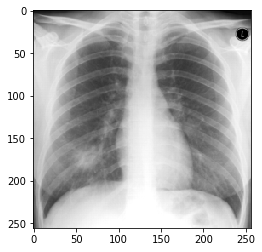

In [15]:
image = np.squeeze(image)
plt.imshow(image, cmap='gray')

In [16]:
train_dataloader = Dataloder(train_dataset, batch_size=1, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=True)

In [17]:
len(train_dataloader), len(test_dataloader)

(42, 11)

In [18]:
for batch_idx, (features, targets) in enumerate(train_dataloader):
    print(batch_idx, features.shape, targets.shape)

0 (1, 256, 256, 1) (1, 2)
1 (1, 256, 256, 1) (1, 2)
2 (1, 256, 256, 1) (1, 2)
3 (1, 256, 256, 1) (1, 2)
4 (1, 256, 256, 1) (1, 2)
5 (1, 256, 256, 1) (1, 2)
6 (1, 256, 256, 1) (1, 2)
7 (1, 256, 256, 1) (1, 2)
8 (1, 256, 256, 1) (1, 2)
9 (1, 256, 256, 1) (1, 2)
10 (1, 256, 256, 1) (1, 2)
11 (1, 256, 256, 1) (1, 2)
12 (1, 256, 256, 1) (1, 2)
13 (1, 256, 256, 1) (1, 2)
14 (1, 256, 256, 1) (1, 2)
15 (1, 256, 256, 1) (1, 2)
16 (1, 256, 256, 1) (1, 2)
17 (1, 256, 256, 1) (1, 2)
18 (1, 256, 256, 1) (1, 2)
19 (1, 256, 256, 1) (1, 2)
20 (1, 256, 256, 1) (1, 2)
21 (1, 256, 256, 1) (1, 2)
22 (1, 256, 256, 1) (1, 2)
23 (1, 256, 256, 1) (1, 2)
24 (1, 256, 256, 1) (1, 2)
25 (1, 256, 256, 1) (1, 2)
26 (1, 256, 256, 1) (1, 2)
27 (1, 256, 256, 1) (1, 2)
28 (1, 256, 256, 1) (1, 2)
29 (1, 256, 256, 1) (1, 2)
30 (1, 256, 256, 1) (1, 2)
31 (1, 256, 256, 1) (1, 2)
32 (1, 256, 256, 1) (1, 2)
33 (1, 256, 256, 1) (1, 2)
34 (1, 256, 256, 1) (1, 2)
35 (1, 256, 256, 1) (1, 2)
36 (1, 256, 256, 1) (1, 2)
37 (1, 256,

In [19]:
for batch_idx, (features, targets) in enumerate(test_dataloader):
    print(batch_idx, features.shape, targets.shape)

0 (1, 256, 256, 1) (1, 2)
1 (1, 256, 256, 1) (1, 2)
2 (1, 256, 256, 1) (1, 2)
3 (1, 256, 256, 1) (1, 2)
4 (1, 256, 256, 1) (1, 2)
5 (1, 256, 256, 1) (1, 2)
6 (1, 256, 256, 1) (1, 2)
7 (1, 256, 256, 1) (1, 2)
8 (1, 256, 256, 1) (1, 2)
9 (1, 256, 256, 1) (1, 2)
10 (1, 256, 256, 1) (1, 2)


In [ ]:
# Define callbacks for learning rate scheduling, logging and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('{}/{}.h5'.format(LOG_PATH, EXPERIMENT_NAME), monitor='val_loss', save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, verbose=1, patience=5, mode='min'), ## new_lr = lr * factor # 5
    keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, verbose=1, patience=15, mode='min', restore_best_weights=True), # 8
    keras.callbacks.CSVLogger('{}/training.csv'.format(LOG_PATH))
]

In [ ]:

start_time = time.time()


history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),  # val samples = batch size * no of steps
)

end_time = time.time()
print("--- Time taken to train : %s hours ---" % ((end_time - start_time)//3600))